Title: Image Segmentation
Author: Thomas Breuel
Institution: UniKL

In [1]:

from pylab import *
from scipy.ndimage import filters,morphology,measurements
from sklearn.cluster import MiniBatchKMeans
from skimage.color import rgb2lab
from skimage import segmentation
from skimage.segmentation import mark_boundaries
gray()

# Segmentation by Thresholding

Let's start with a simple segmentation problem. These are red blood cells under a microscope.

In [2]:
cells = imread("micro8.jpg")
gcells = mean(cells,2)
imshow(gcells)

/usr/lib/pymodules/python2.7/matplotlib/image.py:1287: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)


We can get a pretty good segmentation simply by _thresholding_.

Thresholding is even more commonly used where we can control _lighting_ and camera placement in industrial vision systems.

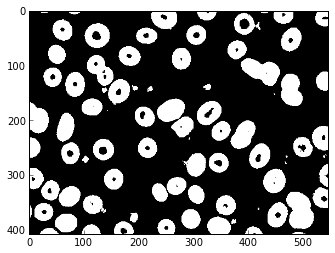

In [3]:
imshow(gcells<mean(gcells))

Note that we can identify the gray values in each population from a histogram.

This also lets us pick the optimal threshold, but that's close to the mean anyway.

208.406331027


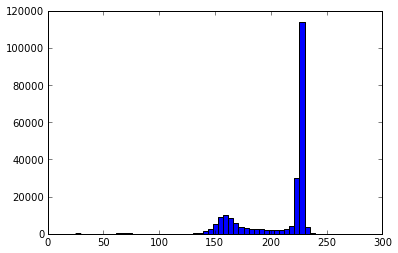

In [4]:
_=hist(gcells.ravel(),bins=50)
print mean(gcells)

The `label` function lets us assign distinct labels to each region. Note that touching cells are not properly segmented.

In [5]:
seg,_ = measurements.label(gcells<mean(gcells))
imshow(seg,cmap=cm.spectral)

We can also overlay the segmentation on top of the original image (using the skimage tools).

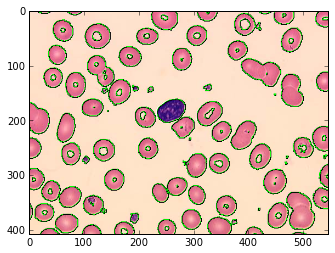

In [6]:
imshow(segmentation.mark_boundaries(cells,seg,color=(0,1,0)))

(constraints)

In simple thresholding, we have just taken advantage of intensity differences and connectivity:

- objects of interest are darker than the background
- objects of interest form connected regions, separated by a connected background

What haven't we taken advantage of?

- cells aren't just blobs, they have a particular appearance (a light center)
- cells are round and project into ellipsoidal (or at least convex) blobs.

When solving segmentation problems (like other problems) as yourself about your _prior knowledge_, and then think about you can can incorporate it.

# Document Binarization

A common form of segmentation is _document binarization_.

We are trying to divide an image into _ink_ and _paper_.

Document binarization is often made more difficult by the presence of variable lighting.

In [7]:
spine = mean(imread("spine.png"),2)
imshow(spine)

In [8]:
imshow(spine>mean(spine))

Document binarization may be difficult due to the presence of variable lighting.

# Segmentation by Adaptive Thresholding

To deal with variable background, we can try to model the variability of the background intensity.

A simple approach is to smooth the page.

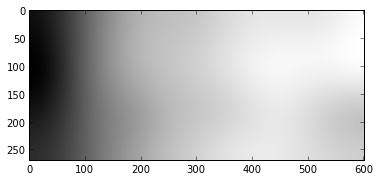

In [9]:
imshow(filters.gaussian_filter(spine,50))

Now we can remove some of the background variability and perform better thresholding.

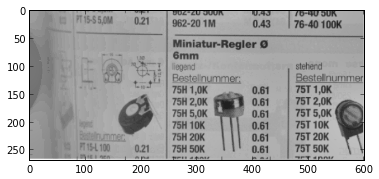

In [10]:
local = spine - filters.gaussian_filter(spine,50)
imshow(local)

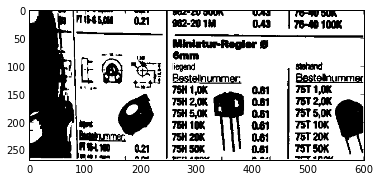

In [11]:
imshow(local>mean(local))

The maximum filter turns out to be a better model, since it models the paper itself.

In [12]:
local = spine-filters.maximum_filter(spine,30,mode='nearest')
imshow(local)

In [13]:
imshow(local>mean(local))

In [14]:
local = spine-filters.median_filter(spine,50,mode='nearest')
imshow(local>mean(local))

# Color Segmentation and Color Clustering

A fairly obvious choice for segmentation of color images is to put "all pixels of the same color" together.

This turns out to be quite hard in general. Let us attempt this.

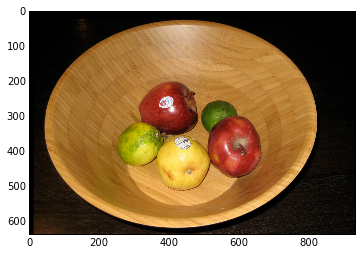

In [15]:
bowl = imread("fruitbowl.png")
imshow(bowl)

We now treat the image as a collection of RGB vectors and use the k-means algorithm to find a small set of clusters.

In [16]:
rgb = bowl.reshape(-1,3)
print amin(rgb),amax(rgb)
km = MiniBatchKMeans(10)
segments = km.fit_predict(rgb).reshape(*bowl.shape[:2])

0.0 1.0


In [17]:
imshow(mark_boundaries(bowl,segments,color=(0,1,0)))

In the resulting image, we observe a number of effects:

- texture causes nearby pixels to have very different color values sometimes (fix by smoothing)
- intensity variation (due to lighting) is treated just like color variation (fix by transforming into a different color space)

In [18]:
blur = filters.gaussian_filter(bowl,(5,5,0))
imshow(blur)

In [19]:
# k-means based color quantization on blurred images
km = MiniBatchKMeans(10)
segments = km.fit_predict(blur.reshape(-1,3)).reshape(*blur.shape[:2])
imshow(mark_boundaries(bowl,segments,color=(0,1,0)))

In [20]:
# transformation into Lab color space
figsize(12,4)
lab = rgb2lab(blur)
for i in range(3): subplot(1,3,i+1); imshow(lab[:,:,i])

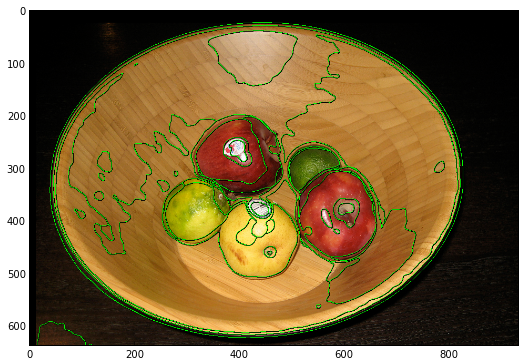

In [21]:
# color clustering only in the ab subspace of Lab
figsize(12,6)
km = MiniBatchKMeans(10)
segments = km.fit_predict(lab.reshape(-1,3)[:,1:]).reshape(*lab.shape[:2])
imshow(mark_boundaries(bowl,segments,color=(0,1,0)))

# Edge-Based Segmentation

All the methods so far are based on similarity of pixel or color values.

We can also use similarity more indirectly, namely by edge detection.

- Find edges by pixels that are locally dissimilar.
- Form boundaries from these edges.
- Segment based on boundaries.

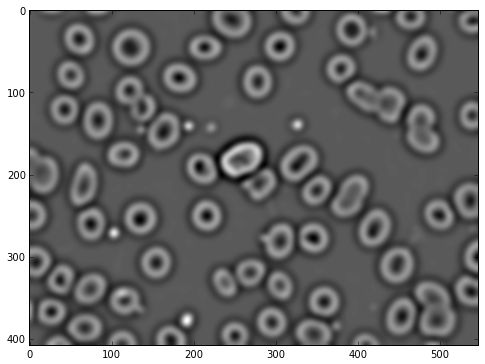

In [22]:
lap = filters.gaussian_laplace(gcells,5.0)
imshow(lap)

In [23]:
edges = (lap>0)*morphology.binary_dilation(lap<0,iterations=3)
imshow(edges)

In [24]:
blobs,n = measurements.label(edges==0)
imshow(blobs,cmap=cm.spectral)

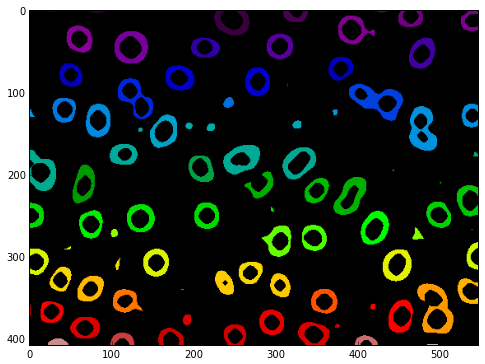

In [25]:
means = measurements.mean(lap,blobs,range(n+1))
selected = (arange(n+1)*(means>0))[blobs]
imshow(selected,cmap=cm.spectral)

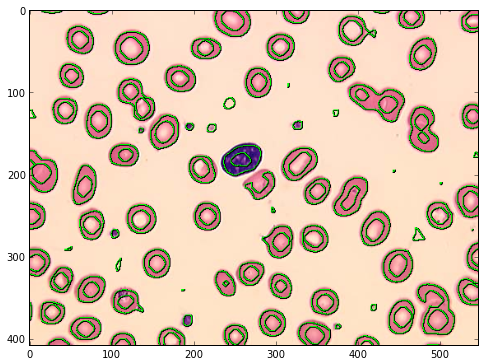

In [26]:
imshow(mark_boundaries(cells,selected,color=(0,1,0)))

# Watershed Segmentation

Watershed segmentation differs from the methods discussed so far in that it requires _markers_.

Starting from markers, and given a set of edges / boundaries, watershed segmentation finds regions.

(watershed algorithm)

- put a source / hole at each marker (e.g., local minimum)
- slowly raise the waterlevel, letting water flow in through each marker hole
- at some point, water is going to rise above a ridge and water from two sources is going to meet
- wherever it meets, mark a watershed boundary

In [27]:
spots = filters.gaussian_filter(mean(imread("blobs.png"),2)[:300,:300],3.0)
imshow(spots)

In [28]:
# constructing the edge image
edges = filters.gaussian_gradient_magnitude(spots,3.0)
imshow(edges)

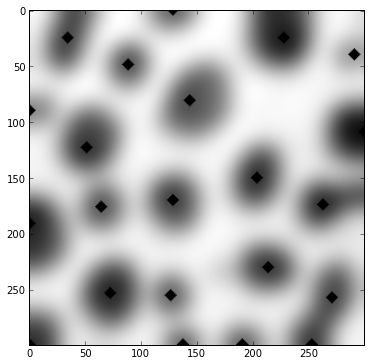

In [29]:
# constructing the marker image
smoothed = filters.gaussian_filter(spots,10.0)
seeds = (smoothed==filters.minimum_filter(smoothed,20))
imshow(smoothed*(1-morphology.binary_dilation(seeds,iterations=5)))

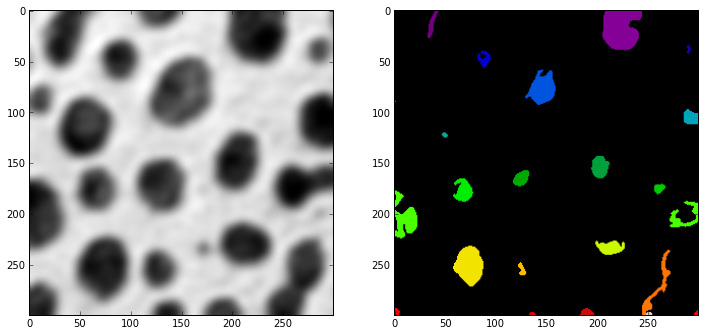

In [30]:
# performing the watershed segmentation
markers,_ = measurements.label(seeds)
segmentation = measurements.watershed_ift(array(255*edges,'B'),markers)
subplot(121); imshow(spots)
subplot(122); imshow(segmentation,cmap=cm.spectral)

# Random-Walk Based Segmentation

Like the watershed algorithm, this algorithm takes:

- an image (or edges)
- a set of starting markers

What is is asking is:

- Starting a random walk at each pixel, what marker is it going to end up at first?
- Walks are easiest where there are no edges in the way.

A direct solution is far too costly, but this is basically the problem of finding the steady state solution of a diffusion equation.

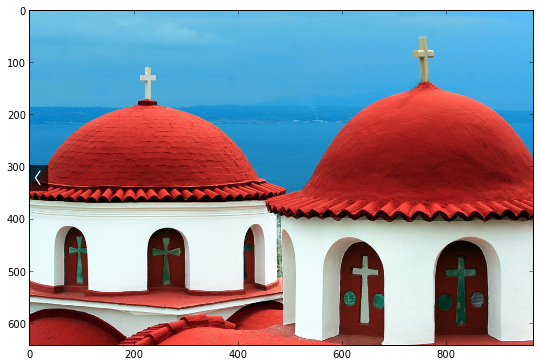

In [31]:
dome = imread("dome.png")
imshow(dome)

In [32]:
markers = zeros(dome.shape[:2],'i')
markers[50,500] = 1
markers[300,200] = 2
markers[300,700] = 3
markers[400,200] = 4
markers[500,700] = 5
markers[-1,400] = 6

In [33]:
from skimage import segmentation
seg = segmentation.random_walker(dome,markers,multichannel=1,mode='cg',beta=1000)

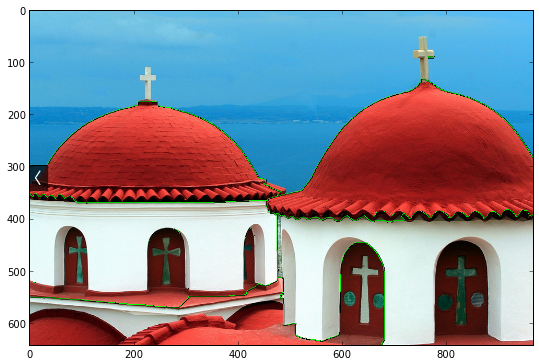

In [34]:
imshow(segmentation.mark_boundaries(dome,seg,color=(0,1,0)))

# Superpixels

(oversegmentation)

As you can see from the above examples, trying to segment an image into regions that are semantically meaningful is hard and usually doesn't work. That's because a lot of top-down knowledge is needed for such segmentations.

A more modest goal is to _oversegment_ the image.

An oversegmentation is a segmentation that attempts to guarantee that segments do not cross semantically meaningful regions, but each semantically meaningful segment may be divided up into multiple superpixels.

(superpixel computation)

A simple and general way of computing superpixels is to treat spatial coordinates just like color or feature vectors.

- At each pixel location, take the RGB triple and turn it into a 5-dimensional vector $(r,g,b,\beta x,\beta y)$
- Here, $\beta$ is a scale factor that determines the strength of the spatial influence.
- Perform $k$-means clustering on the collection of 5-vectors from the entire image.
- Map the clusters back to image segments.

(643, 967, 5)


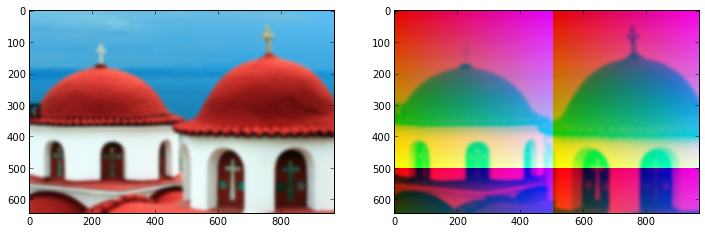

In [35]:
# construct 5D image
dome = imread("dome.png")
h,w,_ = dome.shape
ys,xs = mgrid[:h,:w]
blur = filters.gaussian_filter(dome,(5,5,0))
sc = transpose(array(list(transpose(blur,[2,0,1]))+[ys/500.0,xs/500.0]),[1,2,0])
print sc.shape
subplot(121); imshow(sc[:,:,:3])
subplot(122); imshow(sc[:,:,2:])

In [36]:
# perform k-means clustering on 5D vectors representing each pixel
km = MiniBatchKMeans(300)
segments = km.fit_predict(sc.reshape(-1,5)).reshape(*sc.shape[:2])

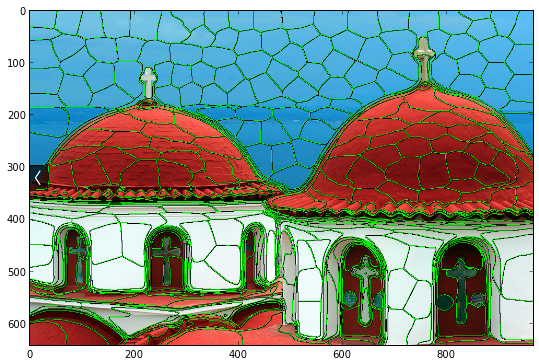

In [37]:
# k-means based superpixels
imshow(segmentation.mark_boundaries(dome,segments,color=(0,1,0)))

In [38]:
# superpixel implementation from the skimage toolkit, here clustering in Lab space
seg = segmentation.slic(dome,n_segments=100,sigma=5.0,convert2lab=1,ratio=20.0)
figsize(10,8)
imshow(segmentation.mark_boundaries(dome,seg,color=(0,1,0)))

In [39]:
# superpixel implementation using mean-shift/medoid-shift clustering
seg = segmentation.quickshift(dome,ratio=0.9,max_dist=300,sigma=5.0)
figsize(10,8)
imshow(segmentation.mark_boundaries(dome,seg,color=(0,1,0)))

# Graph Cuts Segmentation

(graph cuts)

A completely different approach to segmentation is based on the idea of _graph cuts_.

Graph cuts construct a special graph and then use a _min cut_ algorithm to find a good way of segmenting the image.

We will illustrate that with a small picture (since these algorithms are not very efficient when implemented directly, although there are better libraries).

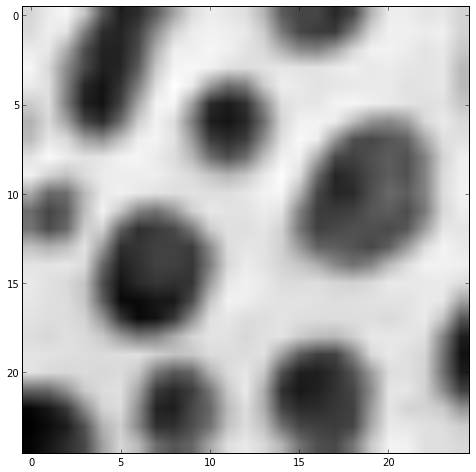

In [40]:
spts = spots[:200,:200]
spts = spts[::8,::8]/amax(spots)
imshow(spts)
n,_ = spts.shape

Let's now construct a special directed graph.

For each pixel in the $n \times n$ image, we add a node to the graph.

In addition, we add two special nodes, a source and a sink.

In [41]:
from pygraph.classes.digraph import digraph
from pygraph.algorithms.minmax import maximum_flow
G = digraph()
G.add_nodes(range(n*n+2))
source = n*n
sink = n*n+1

Graph cut methods segment the image into two parts.

We assume that we have some measure of affinity of each pixel to the foreground and the background segment.

In this case, we just use the intensity itself, but often, this is the output from a classifier $P(\hbox{foreground}|x,y)$.

We connect the source to the image pixels with the foreground affinity, and the sink to the image pixels with the background affinity.



In [42]:
v = spts.ravel()
for i,x in enumerate(v):
    G.add_edge((source,i),wt=v[i])
    G.add_edge((i,sink),wt=1-v[i])

In addition, we add links between pixels based on the intensity similarity of these pixels to their neighbors.



In [43]:
for x in range(1,n-1):
    for y in range(1,n-1):
        G.add_edge((y*n+x,y*n+x+1),wt=exp(-(spts[y,x]-spts[y,x+1])**2/0.1**2))
        G.add_edge((y*n+x,(y+1)*n+x),wt=exp(-(spts[y,x]-spts[y+1,x])**2/0.1**2))
        G.add_edge((y*n+x,y*n+x-1),wt=exp(-(spts[y,x]-spts[y,x-1])**2/0.1**2))
        G.add_edge((y*n+x,(y-1)*n+x),wt=exp(-(spts[y,x]-spts[y-1,x])**2/0.1**2))

Now we run the `maximum_flow` algorithm.

This algorithm returns a minimal cut, that is the minimal set of edges that needs to be cut in order to stop the entire flow.

The cut is returned by simply categorizing each node in the graph into whether it lies on one side of the cut or the other; in different words, the `maximum_flow` algorithm effectively just returns the segmentation.



In [44]:
flows,cuts = maximum_flow(G,source,sink)

To see the segmentation, we just put the cut information back into image form.




In [45]:
seg = array([cuts[i] for i in range(n*n)]).reshape(n,n)
subplot(121); imshow(spts)
subplot(122); imshow(seg)

# Classifiers and Segmentation

(How do we apply segmentation?)

- Color-based segmentation is often unreliable due to the presence of texture.
- We may need to compute texture descriptors (and color texture descriptors) at each pixel.
- Alternatively, we may compute classifier output at each pixel.
- Texture and color descriptors give a vectorial output at each location and amount to a nearest neighbor classifier.
- Classifiers and vectorial outputs differ in that classifiers output specific classes, while vectorial outputs require the segmenter to discover the classes.

